In [49]:
import sys
sys.path.insert(0, '../')

import pandas as pd
import numpy as np

from hedging import hedging_pnl
from Black76 import Black76

### Price data

In [50]:
df = pd.read_csv('../data/data_hedging.csv', sep=';')
df = df.drop(columns=['Unnamed: 2'])
t_grid = np.array(df['Date'])
S_traj = np.array(df['Spot'])
df

,Date,Spot
0,0.000,101.53
1,0.004,100.99
2,0.008,99.99
3,0.012,100.00
4,0.016,101.93
...,...,...
194,0.776,67.21
195,0.780,66.69
196,0.784,67.07
197,0.788,67.67


### Model and option parameters

In [47]:
K = 98.88
T = 0.824
sigma = 0.2913
r = 0.05

flag = 'c'
S0 = S_traj[0]
F0 = S0 * np.exp(r * T)

model = Black76(sigma=sigma, r=r)
def delta_Black(t, S, model=model, T=T, K=K, flag=flag):
    return model.delta(T - t, K, S * np.exp(r * (T - t)), flag)
def call_payoff(x, K=K):
    return np.maximum(x - K, 0)
V0 = model.vanilla_price(T, K, F0, flag)

In [48]:
pnl, V = hedging_pnl(t_grid, S_traj, r, delta_Black, V0, call_payoff)
pnl

-0.12220342250402894

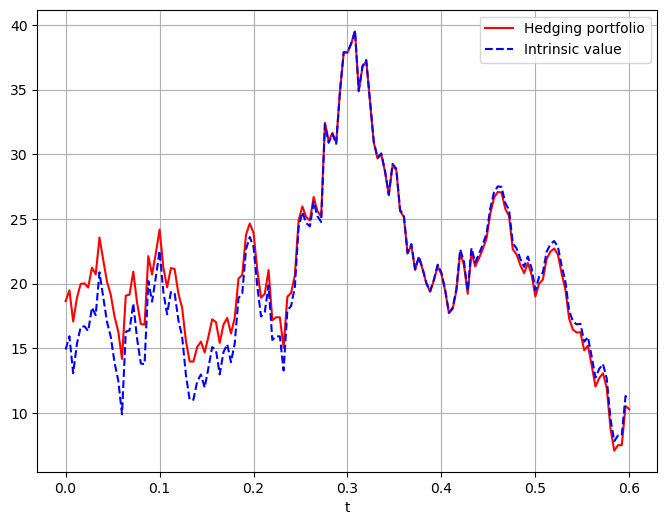

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(t_grid, V, 'r', label='Hedging portfolio')
ax.plot(t_grid, call_payoff(S_traj), 'b--', label='Intrinsic value')
ax.set_xlabel('t')
ax.legend()
ax.grid()

## Distribution of the hedging error in BS market

In [40]:
K = 98.88
T = 0.824
sigma = 0.2913
r = 0.05

flag = 'c'
S0 = S_traj[0]
F0 = S0 * np.exp(r * T)

model = Black76(sigma=sigma, r=r)

#### Generating trajs

In [41]:
n_sample = 10**4
t_grid_size = 250
t_grid = np.linspace(0, T, t_grid_size)
rng = np.random.default_rng(seed=0xAB0BA)
S_traj = model.simulate_trajectory(
    size=n_sample,
    t_grid=t_grid,
    init_val=S0,
    flag='spot',
    rng=rng
)

In [42]:
V0 = model.vanilla_price(T, K, F0, flag)
def delta_Black(t, S, model=model, T=T, K=K, flag=flag):
    return model.delta(T - t, K, S * np.exp(model.r * (T - t)), flag)
def call_payoff(x, K=K):
    return np.maximum(x - K, 0)

In [43]:
pnl, V = hedging_pnl(
    t_grid=t_grid,
    S_traj=S_traj,
    r=r,
    delta=delta_Black,
    init_value=V0,
    payoff=call_payoff
)

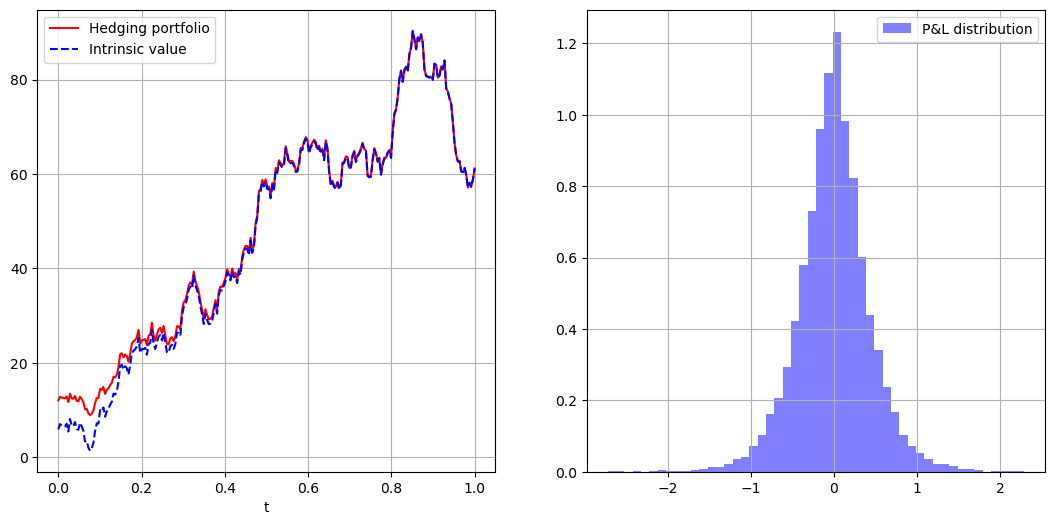

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(13, 6))

ax[0].plot(t_grid, V[1], 'r', label='Hedging portfolio')
ax[0].plot(t_grid, call_payoff(S_traj[1], K=K), 'b--', label='Intrinsic value')
ax[0].set_xlabel('t')
ax[0].legend()
ax[0].grid()

ax[1].hist(pnl, color='b', alpha=0.5, label='P&L distribution', density=True, bins=50)
ax[1].legend()
ax[1].grid()

## P&L of trader using a local vol model

In [51]:
K = 109.69
T = 0.792
sigma_model = 0.2519
sigma_true = 0.2857
r = 0.034
flag = 'p'

In [52]:
model = Black76(sigma=sigma_model, r=r)

In [53]:
df = pd.read_csv('../data/data_hedging.csv', sep=';')
df = df.drop(columns=['Unnamed: 2'])
t_grid = np.array(df['Date'])
S_traj = np.array(df['Spot'])

S0 = S_traj[0]
F0 = S0 * np.exp(r * T)

df

,Date,Spot
0,0.000,101.53
1,0.004,100.99
2,0.008,99.99
3,0.012,100.00
4,0.016,101.93
...,...,...
194,0.776,67.21
195,0.780,66.69
196,0.784,67.07
197,0.788,67.67


In [54]:
gammas = model.gamma(T=T - t_grid, K=K, F=S_traj * np.exp(r * (T - t_grid)))
0.5 * (sigma_model**2 - sigma_true**2) * np.sum(np.diff(t_grid) * np.exp(r * (T - t_grid[:-1])) * S_traj[:-1]**2 * gammas[:-1])

../Black76.py:130: RuntimeWarning: invalid value encountered in divide
  return norm.pdf(d1) / (np.exp(-self.r * T) * F * self.sigma * np.sqrt(T))


-0.8927988951226632